# Final Project - Almost Nbody simulation

I uploaded a pdf where I explain my ideas for this code.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

First, create a function that returns the FFT of the green function on the grid

In [136]:
def green_function(n,shift):
    '''
    n: number of bins
    shift: because my system of reference goes from 0 to L, this centers the Green function
    RETURNS: the fft of the green function
    '''
    x = np.arange(0,n+1)
    y = x.copy()
    x_mid = []
    y_mid = []
    # calculate the midpoint
    for i in range(n):
        x_mid.append((x[i]+x[i+1])/2)
        y_mid.append((y[i]+y[i+1])/2)
    X,Y = np.meshgrid(x_mid,y_mid)
    '''
    plt.grid()
    plt.plot(X,Y,'.')
    plt.xticks(x)
    plt.yticks(y)
    plt.show()
    '''
    eps = 0.5
    # move to the center of the grid in case the length goes from 0...L
    R = 4*np.pi*np.sqrt((X-shift)**2 + (Y-shift)**2+eps**2)
    G = 1.0/R
    Gft = np.fft.rfft2(G)
    return Gft



Now the function nbodyevolve takes:

- the x and y positions of the particles
- the vx and vy velocities of the particles
- dt the time step
- the number of bins on the grid
- the FT of the green's function

and returns:

- new x position, new y position
- total energy
- potential
Only for part 2:
- force on particle 1
- distance between particles
otherwise, comment those variables.
 

In [135]:
def nbodyevolve(x,y,vx,vy,dt,nbins,Gft):
    # Get density
    rho,x_edges,y_edges = np.histogram2d(x,y,bins=nbins,range=[[0,nbins],[0,nbins]],normed=True)
    #print(rho)
    #print('xi',x)
    #print('yi',y)
    # Find the index position of the particles
    x_index = []
    y_index = []   
    for i in range(len(rho)):
        for j in range(len(rho)):
            if rho[i,j]!=0:
                x_index.append(j)
                y_index.append(i)
    # compute fourier transform of rho 
    rhoft = np.fft.rfft2(rho)
    aux = rhoft*Gft
    # compute phi, the potential
    phi = np.fft.irfft2(aux) 
    #Roll when the nbins is odd
    if nbins%2 != 0:
        phi = np.roll(phi,1,axis=(0,1)) 
    phi = np.fft.fftshift(phi) 
    phi = phi.transpose()
    # Calculate the force, which is equal to a
    a = np.gradient(phi)
    #print(a)
    ax = a[0]
    ay = a[1]
    #print('ax',a[0])
    #print('ay',a[1]) 
    ax_particle=[]
    ay_particle=[]
# update positions
    x += vx*dt
    y += vy*dt 
# update velocities
    for i in range(len(y_index)):
        #print('i',i)
        # number of particles inside bin
        yy = y_index[i]
        #print('yy',yy)
        xx = x_index[i]
        #print('xx',xx)
        #print('ax index',ax[yy,xx])
        #print('ay index',ay[yy,xx])
        vx[i]+= ax[yy,xx]*dt
        vy[i]+= ay[yy,xx]*dt
        ax_particle.append(ax[yy,xx])
        ay_particle.append(ay[yy,xx])
    #print('vx',vx)
    #print('vy',vy)

# calculate the energy
    Ekin = 0.5*np.sum(vx**2+vy**2)
    Epot = 0.5*np.sum(phi)
    Etot = Ekin+Epot 
    
### this is for part 2    
# calculate magnitude of the force over particle 1
    #f1 = np.sqrt(ax_particle[0]**2+ay_particle[0]**2)
# and the distance between the particles
    #r = np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2)
    return x,y,Etot,phi#,f1,r

# Part 1

In [290]:
# Set the number of particles
N = 1

# Set the dimensions of the grid (I'll choose a square grid)

nbins = 255


x = np.array([nbins/2.0])
y = np.array([nbins/2.0])

# create a grid to calculate Green's function
green = green_function(nbins,nbins/2)

vx = np.array([0.0])
vy = vx.copy()
  
niter = 100
dt = 0.1
e_tot = []

for i in range(niter):
    x_new,y_new,Etot,phi = nbodyevolve(x,y,vx,vy,dt,nbins,green)
    e_tot.append(Etot)
    plt.ylim(0,nbins)
    plt.xlim(0,nbins)
    plt.plot(x_new,y_new,'.')
    plt.title(str(i)+' iteration')
    plt.savefig('write_{:06}.png'.format(i))
    plt.close()

    
# once i have all the pictures, to make the video write on the terminal:
# ffmpeg -framerate 30 -pattern_type glob -i '*.png'   -c:v libx264 -pix_fmt yuv420p out.mp4


Keep track of the energy

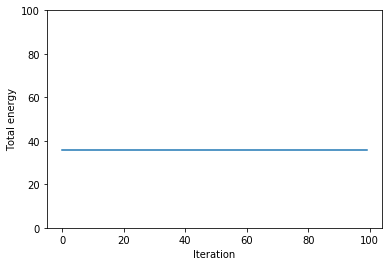

In [292]:
plt.plot(e_tot)
plt.ylim(0,100)
plt.xlabel('Iteration')
plt.ylabel('Total energy')
#plt.legend(loc='best')
plt.show()

## Part 2

For the two bodies to remain in circular orbit, the centripetal force must be equal to gravity. So, for particle 1, which distance to the center is $r_1$:

\begin{equation}
m_1 \frac{v_1^2}{r_1} = \frac{Gm_1 m_2}{(r_1+r_2)^2}
\end{equation}

but we are assuming that $G=m_1=m_2=1$. Also, $r_1=r_2$. So:

\begin{equation}
v_1 = \frac{1}{2\sqrt{r_1}}
\end{equation}

Since the idea is that the particles start with the same velocities, but opposite: $v_1 = - v_2$.
Setting these conditions should result in a circular orbit.

In my code, I put the particles at a distance $R/2$ from the center of the grid, so that the total distance is $R$. The initial velocities are set according to the equation above.

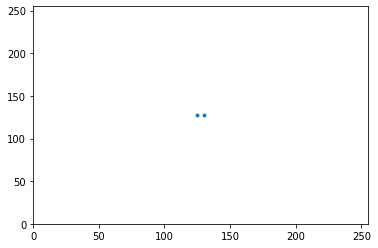

In [308]:
### Part 2
nbins = 255

# first set the distance between the particles (must remain constant approx)
R = 5.0
# now the positions:
y = np.array([nbins/2.0,nbins/2.0])
x = np.array([(nbins/2.0)-(R/2.0),(nbins/2.0)+(R/2.0)])

plt.plot(x,y,'.')

plt.xlim(0,nbins)
plt.ylim(0,nbins)
vx = np.array([0.0,0.0])
vy = np.array([-1.0/(2*np.sqrt(R)),1.0/(2*np.sqrt(R))])

green = green_function(nbins,nbins/2.0)

In [310]:
e_tot = []
f_particle1 = []
distance = []
dt = 0.01
for i in range(2000):
    x_new,y_new,Etot,pot,f,d = nbodyevolve(x,y,vx,vy,dt,nbins,green)
    e_tot.append(Etot)
    f_particle1.append(f)
    distance.append(d)
    '''
    plt.figure()
    plt.pcolormesh(pot)
    plt.plot(y_new,x_new,'.',color='red')
    plt.xlim(0,nbins)
    plt.ylim(0,nbins)
    plt.show()
    ###
    '''
    plt.plot(x_new,y_new,'.',color='red')
    plt.xlim(90,150)
    plt.ylim(90,150)
    plt.title(str(i)+' iteration')
    plt.savefig('write_{:06}.png'.format(i))
    plt.close()

Because clearly my code is not working, I plot below:

- the total energy
- the distance between the particles at each iteration
- the force on particle 1 at each iteration

If the orbit is circular, I should observe:

- Approximately constant energy
- Approximately constant distance
- Approximately constant force

But I observe instead:

- energy IS approx. constant
- distance increases with iteration
- force oscillates

The only explanation I could find is that the code is failing. Specifically, since the force is not constant, the big must be here or when I calculate the potential. Honestly, I couldn't find it :(

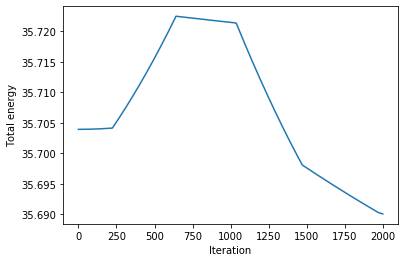

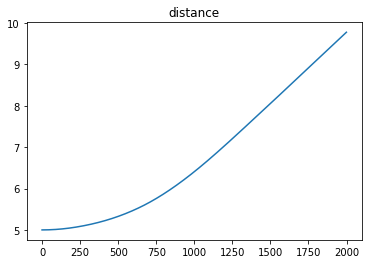

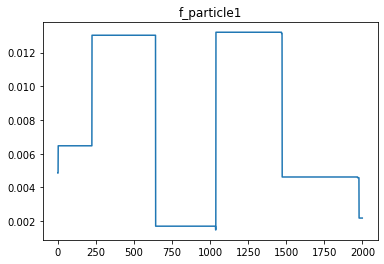

In [311]:
plt.figure()
plt.plot(e_tot)
plt.xlabel('Iteration')
plt.ylabel('Total energy')

plt.show()
plt.figure()
plt.plot(distance)
plt.title('distance')
plt.show()

plt.figure()
plt.plot(f_particle1)
plt.title('f_particle1')
plt.show()

### Part 3

### For periodic boundary conditions

Here I use the same function as in parts 1 and 2, but adding extra lines that force the particle's positions to be at the opposite edge when they reach one of the edges. This results in periodic boundary conditions.

In [137]:
def nbodyevolve(x,y,vx,vy,dt,nbins,Gft,bc):
    # Get density
    rho,x_edges,y_edges = np.histogram2d(x,y,bins=nbins,range=[[0,nbins],[0,nbins]],normed=True)

    # Find the index position of the particles
    x_index = []
    y_index = []   
    for i in range(len(rho)):
        for j in range(len(rho)):
            if rho[i,j]!=0:
                x_index.append(j)
                y_index.append(i)
    # compute fourier transform of rho 
    rhoft = np.fft.rfft2(rho)
    aux = rhoft*Gft
    # compute phi, the potential
    phi = np.fft.irfft2(aux) 
    #Roll when the nbins is odd
    if nbins%2 != 0:
        phi = np.roll(phi,1,axis=(0,1)) 
    phi = np.fft.fftshift(phi) 
    phi = phi.transpose()
    # Calculate the force, which is equal to a
    a = np.gradient(phi)
    #print(a)
    ax = a[0]
    ay = a[1]
    #print('ax',a[0])
    #print('ay',a[1])   
# update velocities
    for i in range(len(y_index)):
        #print('i',i)
        # number of particles inside bin
        yy = y_index[i]
        #print('yy',yy)
        xx = x_index[i]
        #print('xx',xx)
        #print('ax index',ax[yy,xx])
        #print('ay index',ay[yy,xx])
        vx[i]+= ax[yy,xx]*dt
        vy[i]+= ay[yy,xx]*dt
    #print('vx',vx)
    #print('vy',vy)
# periodic conditions
    if bc=='periodic':
        for i in range(len(x)):
            if x[i]>x_edges[-1]:
                x[i] = x[i]-nbins
            if x[i]<x_edges[0]:
                x[i] = x[i]+nbins
            if y[i]>y_edges[-1]:
                y[i] = y[i]-nbins
            if y[i]<y_edges[0]:
                y[i] = y[i]+nbins
# update positions
    x += vx*dt
    y += vy*dt 
    #print('x',x)
    #print('y',y)
# calculate the energy
    Ekin = 0.5*np.sum(vx**2+vy**2)
    Epot = 0.5*np.sum(phi)
    Etot = Ekin+Epot    
    
    return x,y,Etot,phi

In [145]:
N = 100000

nbins = 512

x = np.random.uniform(0, nbins, N)
y = np.random.uniform(0, nbins, N)

# create a grid to calculate Green's function
green = green_function(nbins,nbins/2)

vx = 0*x
vy = vx.copy()

#plt.figure()
#plt.plot(x,y,'.')
#plt.ylim(0,L)
#plt.xlim(0,L)    
niter = 2000
dt = 100.0
e_tot = []


for i in range(niter):
    x_new,y_new,Etot,pot = nbodyevolve(x,y,vx,vy,dt,nbins,green,bc='periodic')
    e_tot.append(Etot)
    #print('vx',vx_new)
    #print('vy',vy_new)
    #plt.figure()
    #plt.pcolormesh(pot)
    #plt.colorbar()
    #plt.grid()
    #plt.scatter(x_new,y_new,color='red')
    #plt.xlim(-L,L)
    #plt.ylim(-L,L)
    #plt.xticks(x_edges)
    #plt.yticks(y_edges)
    #plt.show()
   
    plt.ylim(0,nbins)
    plt.xlim(0,nbins)
    plt.imshow(pot)
    #plt.scatter(x_new,y_new,color='red')
    plt.title(str(i)+' iteration')
    plt.savefig('write_{:06}.png'.format(i))
    plt.close()
   
   

Watch the video!

Now keep track of the energy, it remains ALMOST constant.

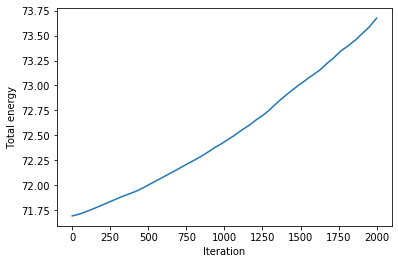

In [148]:
plt.plot(e_tot)
plt.xlabel('Iteration')
plt.ylabel('Total energy')
plt.show()

### For non periodic boundary conditions

The idea is to remove the periodicity imposed by the FFT. To do this:
- Add empty space around the original
- calculate the potential using the new grid
- remove the particles that lie outside the original grid
- remove the extra space

## Part 4

What I understand here is that the initial mass density should now have fluctuations proportional to $k^{-3}$. To do this:

- take the FFT of the initial density $\rho_i$ and compute $\rho_i^{3}$ in the fourier space. This should be $k^3$.
- Add fluctuations proportional to $k^{-3}$, i.e., random noise = $c k^{-3}$, where $c$ is chosen.
- take the IFFT of the new density

The mass is incorporated by adding the weight parameter in np.histogram2d, so now we have to give an extra array of masses. These masses are obtained from the new density. But how do we assign masses from the new density matrix?
To do this

- find the bins with particles
- Let the new mass be a fraction of the old mass


In [149]:
def new_mass(x,y,nbins,c,m):
    rho = np.histogram2d(x,y,bins=nbins,range=[[0,nbins],[0,nbins]],weights=m,normed=True)[0]
    # saves the index of the bins with particles
    x_index = []
    y_index = []   
    for i in range(len(rho)):
        for j in range(len(rho)):
            if rho[i,j]!=0:
                x_index.append(j)
                y_index.append(i)
    # compute fourier transform of rho 
    rhoft = np.fft.rfft2(rho)
    k3 = rhoft**3
    rho_newft = rhoft + c*np.random.randn(rhoft.shape[0],rhoft.shape[1])/k3
    rho_new = np.abs(np.fft.irfft2(rho_newft))
    rho_new = np.fft.fftshift(rho_new)
    new_mass = np.zeros(x.shape)
    #print(rho_new)
    for i in range(len(y_index)):
        yy = y_index[i]
        xx = x_index[i]
        new_mass[i]=rho_new[yy,xx]/rho[yy,xx]

    return new_mass


In [150]:
def nbodyevolvemass(x,y,vx,vy,dt,nbins,Gft,m,bc):
    rho,x_edges,y_edges = np.histogram2d(x,y,bins=nbins,range=[[0,nbins],[0,nbins]],normed=True,weights=m)
    x_index = []
    y_index = []   
    for i in range(len(rho)):
        for j in range(len(rho)):
            if rho[i,j]!=0:
                x_index.append(j)
                y_index.append(i)
    rhoft = np.fft.rfft2(rho)
    aux = rhoft*Gft
    phi = np.fft.irfft2(aux) 
    if nbins%2 != 0:
        phi = np.roll(phi,1,axis=(0,1)) 
    phi = np.fft.fftshift(phi) 
    phi = phi.transpose()
    a = np.gradient(phi)
    ax = a[0]
    ay = a[1] 
# update velocities
    for i in range(len(y_index)):
        yy = y_index[i]
        xx = x_index[i]
        vx[i]+= ax[yy,xx]*dt
        vy[i]+= ay[yy,xx]*dt
# periodic conditions
    if bc=='periodic':
        for i in range(len(x)):
            if x[i]>x_edges[-1]:
                x[i] = x[i]-nbins
            if x[i]<x_edges[0]:
                x[i] = x[i]+nbins
            if y[i]>y_edges[-1]:
                y[i] = y[i]-nbins
            if y[i]<y_edges[0]:
                y[i] = y[i]+nbins
# update positions
    x += vx*dt
    y += vy*dt 
# calculate the energy
    Ekin = 0.5*np.sum(vx**2+vy**2)
    Epot = 0.5*np.sum(phi)
    Etot = Ekin+Epot    
    
    return x,y,Etot,phi

Now run the same simulation of part 3, but with the new masses.

In [151]:
N = 100000

nbins = 512

x = np.random.uniform(0, nbins, N)
y = np.random.uniform(0, nbins, N)

green = green_function(nbins,nbins/2)

x = np.random.uniform(0, nbins, N)
y = np.random.uniform(0, nbins, N)

vx = 0*x
vy = vx.copy()

m = np.ones(x.shape)
mass_k3 = new_mass(x,y,nbins,1.0,m)

niter = 2000
dt = 100
e_tot = []

for i in range(niter):
    x_new,y_new,Etot,pot= nbodyevolvemass(x,y,vx,vy,dt,nbins,green,mass_k3,bc='periodic')
    e_tot.append(Etot)
    plt.ylim(0,nbins)
    plt.xlim(0,nbins)
    plt.imshow(pot)
    plt.title(str(i)+' iteration')
    plt.savefig('write_{:06}.png'.format(i))
    plt.close()

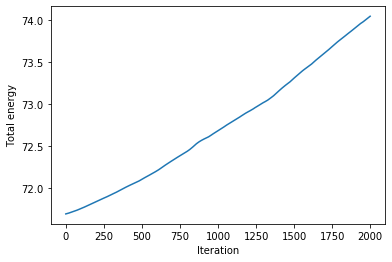

In [152]:
plt.plot(e_tot)
plt.xlabel('Iteration')
plt.ylabel('Total energy')
#plt.legend(loc='best')
plt.show()

# HAPPY HOLIDAYS!!!!!!!!!